In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import random
from collections import defaultdict
import time
import datetime
import warnings

random.seed(42)
np.random.seed(42)

In [3]:
%%capture
from tqdm.notebook import tqdm
tqdm().pandas()

In [4]:
subdir = os.path.join(os.getcwd(), "scraped_processed")
urldir = os.path.join(os.getcwd(), "url_generator")
zipdir = os.path.join(os.getcwd(), "zip_maps")
poidir = os.path.join(os.getcwd(), "dataverse_files_poi")
recdir = os.path.join(os.getcwd(), "recsys")

In [5]:
df_rest = pd.read_csv(os.path.join(subdir, "restaurants_final.csv"))

df_rest["restaurant_ID"] = df_rest["restaurant_ID"].astype("str")
df_rest["restaurant_name"] = df_rest["restaurant_name"].astype("str")
df_rest["restaurant_neighborhood"] = df_rest["restaurant_neighborhood"].astype("str")
df_rest["restaurant_address"] = df_rest["restaurant_address"].astype("str")
df_rest["ZIP_CODE"] = df_rest["ZIP_CODE"].astype("str")
df_rest["City"] = df_rest["City"].astype("str")
df_rest["price"] = df_rest["price"].astype("float")
df_rest["latitude"] = df_rest["latitude"].astype("float")
df_rest["longitude"] = df_rest["longitude"].astype("float")

print(len(df_rest))
df_rest.head(5)

3425


,restaurant_name,restaurant_ID,restaurant_address,price,restaurant_neighborhood,restaurant_closed,ZIP_CODE,City,latitude,longitude
0,Grassona’s Italian,grassonas-italian-brookline,1704 Beacon St,2.0,Brookline,1,2445,Brookline,42.324397,-71.13933
1,Chiharu,chiharu-brookline,370 Boylston St,2.0,Brookline,0,2445,Brookline,42.324397,-71.13933
2,Knight Moves Cafe,knight-moves-cafe-brookline,1402 Beacon St,1.0,Brookline,0,2446,Brookline,42.344747,-71.12141
3,Fugakyu Japanese Cuisine,fugakyu-japanese-cuisine-brookline-2,1280 Beacon St,2.0,Brookline,0,2446,Brookline,42.344747,-71.12141
4,Brothers Restaurant,brothers-restaurant-brookline,404 Harvard St,2.0,Brookline,1,2446,Brookline,42.344747,-71.12141


In [6]:
df_reviews = pd.read_csv(os.path.join(subdir, "reviews_final.csv"), low_memory=False)

df_reviews["reviewer_ID"] = df_reviews["reviewer_ID"].astype("str")
df_reviews["restaurant_ID"] = df_reviews["restaurant_ID"].astype("str")
df_reviews["useful_count"] = df_reviews["useful_count"].astype("float64")
df_reviews["funny_count"] = df_reviews["funny_count"].astype("float64")
df_reviews["cool_count"] = df_reviews["cool_count"].astype("float64")
df_reviews["review_rating"] = df_reviews["review_rating"].astype("float64")
df_reviews["review_date"] = pd.to_datetime(df_reviews["review_date"])
df_reviews["review_year"] = df_reviews["review_date"].dt.year
df_reviews = df_reviews[df_reviews["review_year"] < 2020]

print(len(df_reviews))
df_reviews.head(5)

217366


,reviewer_ID,restaurant_ID,useful_count,funny_count,cool_count,review_rating,review_date,review_year
1,nl8gWLDo6U6MjqzbBmE_9A,chiharu-brookline,2.0,1.0,1.0,4.0,2018-08-13,2018
2,nl8gWLDo6U6MjqzbBmE_9A,knight-moves-cafe-brookline,3.0,1.0,2.0,4.0,2018-06-26,2018
3,nl8gWLDo6U6MjqzbBmE_9A,fugakyu-japanese-cuisine-brookline-2,3.0,NaN,3.0,3.0,2018-06-24,2018
4,nl8gWLDo6U6MjqzbBmE_9A,brothers-restaurant-brookline,4.0,NaN,NaN,3.0,2017-11-29,2017
5,nl8gWLDo6U6MjqzbBmE_9A,los-amigos-taqueria-brookline,3.0,5.0,3.0,3.0,2017-05-20,2017


In [7]:
df_reviews["review_rating"].describe()

count    217366.000000
mean          3.679545
std           1.081987
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: review_rating, dtype: float64

In [8]:
active_uids = (df_reviews["reviewer_ID"].value_counts()[df_reviews["reviewer_ID"].value_counts() > 10].index.tolist())
df_reviews = df_reviews[df_reviews["reviewer_ID"].isin(active_uids)]

active_iids = (df_reviews["restaurant_ID"].value_counts()[df_reviews["restaurant_ID"].value_counts() > 10].index.tolist())
df_reviews = df_reviews[df_reviews["restaurant_ID"].isin(active_iids)]

active_uids = (df_reviews["reviewer_ID"].value_counts()[df_reviews["reviewer_ID"].value_counts() > 10].index.tolist())
df_reviews = df_reviews[df_reviews["reviewer_ID"].isin(active_uids)]

active_iids = (df_reviews["restaurant_ID"].value_counts()[df_reviews["restaurant_ID"].value_counts() > 10].index.tolist())
df_reviews = df_reviews[df_reviews["restaurant_ID"].isin(active_iids)]

df_reviews = df_reviews.drop_duplicates(subset=["reviewer_ID", "restaurant_ID", "review_rating"])

In [9]:
print("#Ratings:", len(df_reviews))
print("#Users", df_reviews["reviewer_ID"].nunique())
print("#Restaurants", df_reviews["restaurant_ID"].nunique())
print("Sparsity:", 1 - len(df_reviews)/(df_reviews["reviewer_ID"].nunique()*df_reviews["restaurant_ID"].nunique()))

#Ratings: 207530
#Users 5520
#Restaurants 2801
Sparsity: 0.9865776456648505


In [10]:
df_tags = pd.read_csv(os.path.join(subdir, "tags_final.csv"))
df_tags = df_tags.groupby("restaurant_ID")["tag"].apply(list).reset_index()
tag_dict = dict(zip(df_tags["restaurant_ID"], df_tags["tag"]))

# Recommender Systems

## SupriseLib

In [11]:
from surprise import NormalPredictor, BaselineOnly, KNNBasic, KNNWithMeans, KNNBaseline, SVD, NMF
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split

In [12]:
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [13]:
def precision_recall_at_k(predictions, k=10, threshold=3):
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [14]:
def get_top_n_predictions(predictions, n=10):

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        ranked_list = []
        for iid, _ in user_ratings[:n]:
            ranked_list.insert(0, iid)
        top_n[uid] = ranked_list

    return top_n


def get_top_n_groundtruth(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r in predictions:
        top_n[uid].append((iid, true_r))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        ranked_list = []
        for iid, _ in user_ratings[:n]:
            ranked_list.insert(0, iid)
        top_n[uid] = ranked_list

    return top_n


# Source: http://ethen8181.github.io/machine-learning/recsys/2_implicit.html#NDCG


def compute_apk(y_true, y_pred, k):
    """
    average precision at k, y_pred is assumed 
    to be truncated to length k prior to feeding
    it to the function
    """
    # convert to set since membership 
    # testing in a set is vastly faster
    actual = set(y_true)
    
    # precision at i is a percentage of correct 
    # items among first i recommendations; the
    # correct count will be summed up by n_hit
    n_hit = 0
    precision = 0
    for i, p in enumerate(y_pred, 1):
        if p in actual:
            n_hit += 1
            precision += n_hit / i

    # divide by recall at the very end
    avg_precision = precision / min(len(actual), k)
    return avg_precision


def dcg_k(score, k=None):
    """
    discounted cumulative gain (dcg)
    
    Parameters
    ----------
    score : 1d nd.array
        ranking/relevance score
        
    k : int, default None
        evaluate the measure for the top-k ranking score,
        default None evaluates all
        
    Returns
    -------
    dcg: float
    """
    if k is not None:
        score = score[:k]

    gain = 2 ** score - 1
    discounts = np.log2(np.arange(2, score.size + 2))
    dcg = np.sum(gain / discounts)
    return dcg


def ndcg_k(score, k=None):
    """
    normalized discounted cumulative gain (ndcg)
    
    Parameters
    ----------
    score : 1d nd.array
        ranking/relevance score
        
    k : int, default None
        evaluate the measure for the top-k ranking score,
        default None evaluates all
        
    Returns
    -------
    ndcg: float, 0.0 ~ 1.0
    """
    actual_dcg = dcg_k(score, k)
    sorted_score = np.sort(score)[::-1]
    best_dcg = dcg_k(sorted_score, k)
    ndcg = actual_dcg / best_dcg
    return ndcg


def ndcg_at_k(predictions, groundtruth, k=10):
    top_n_pred = get_top_n_predictions(predictions, n=k)
    top_n_gt = get_top_n_groundtruth(groundtruth, n=k)
    ndcg_sum = 0
    for uid in top_n_gt.keys():
        score = []
        for iid in top_n_pred[uid]:
            if iid in top_n_gt[uid]:
                score.append(top_n_gt[uid].index(iid) + 1)
            else:
                score.append(0)
        if np.sum(np.array(score)) > 0:        
            ndcg_sum += ndcg_k(np.array(score), k)

    mean_ndcg = ndcg_sum/len(top_n_gt.keys())
    
    return mean_ndcg

In [15]:
def get_metrics(predictions, k=5, threshold=3.5, verbose_=False):
    precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=threshold)

    prec_ = sum(prec for prec in precisions.values()) / len(precisions)
    recall_ = sum(rec for rec in recalls.values()) / len(recalls)
    f1_ = (2 * prec_ * recall_) / (prec_ + recall_)

    rmse_ = accuracy.rmse(predictions, verbose=False)
    mae_ = accuracy.mae(predictions, verbose=False)

    if verbose_:
        print("PRECISION:", round(prec_, 3))
        print("RECALL", round(recall_, 3))
        print("RMSE", round(rmse_, 3))
        print("MAE", round(mae_, 3))
        print("F1", round(f1_, 3))
        print("###############################")

    return prec_, recall_, rmse_, mae_, f1_

In [16]:
def build_model(data, algo, n_split=5, k_=5, th_=3.5, verbose=False, v_time=True):
    kf = KFold(n_splits=n_split)

    pbar = tqdm(total=n_split, desc="Progress:")

    sum_prec_ = 0
    sum_recall_ = 0
    sum_f1_ = 0
    sum_rmse_ = 0
    sum_mae_ = 0

    start_t = time.time()
    i = 0

    for trainset, testset in kf.split(data):
        i += 1
        if verbose:
            print("Fold:", i)

        algo.fit(trainset)
        predictions = algo.test(testset)

        prec_, recall_, rmse_, mae_, f1_ = get_metrics(predictions, k_, th_, verbose)

        sum_prec_ += prec_
        sum_recall_ += recall_
        sum_f1_ += f1_
        sum_rmse_ += rmse_
        sum_mae_ += mae_

        pbar.update(1)

    print("K:", k_)
    print("Threshold:", th_)
    print("AVERAGE PRECISION:", round(sum_prec_ / n_split, 3))
    print("AVERAGE RECALL:", round(sum_recall_ / n_split, 3))
    print("AVERAGE F1:", round(sum_f1_ / n_split, 3))
    print("AVERAGE RMSE:", round(sum_rmse_ / n_split, 3))
    print("AVERAGE MAE:", round(sum_mae_ / n_split, 3))

    if v_time:
        end_t = time.time()
        print("Time Elapsed (mins):", round((end_t - start_t) / 60, 3))

In [17]:
def build_model_k(data, algo, n_split=5, th_=3.5, k_list=[3, 5, 10, 20]):
    kf = KFold(n_splits=n_split)

    k_res = []
    pbar = tqdm(total=n_split * len(k_list), desc="Progress:")
    
    df_result = pd.DataFrame(columns=["K", "Threshold", "precision", "recall", "rmse", "mae", "f1","Time Taken"])
    c = 0
    
    for trainset, testset in kf.split(data):
        start_t = time.time()

        algo.fit(trainset)
        predictions = algo.test(testset)

        model_time = (time.time() - start_t)

        for k_i in k_list:
            prec_, recall_, rmse_, mae_, f1_ = get_metrics(predictions, k_i, th_)
            
            df_result.loc[c] = [k_i, th_, prec_, recall_, rmse_, mae_, f1_, model_time]
            c += 1
            
            pbar.update(1)
            
            
    df_result = df_result.groupby(["K", "Threshold"])[["precision", "recall", "f1", "rmse", "mae", "Time Taken"]
                                                     ].mean().reset_index()

    return df_result

### Metric Parameters

In [18]:
K_ = 10
Th_ = 3.5
K_list = list(range(1, 11))

### NormalPredictor

In [19]:
reader = Reader(rating_scale=(1, 5))

df_ratings = df_reviews[["reviewer_ID", "restaurant_ID", "review_rating"]].copy(deep=True)

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_ratings[["reviewer_ID", "restaurant_ID", "review_rating"]], reader)

algo = NormalPredictor()

# build_model(data, algo, 5, K_, Th_, verbose=False)

In [20]:
res_np = build_model_k(data, algo, n_split=5, th_=Th_, k_list=K_list)
res_np["model"] = "NormalPredictor"
res_np

,K,Threshold,precision,recall,f1,rmse,mae,Time Taken,model
0,1.0,3.5,0.602960,0.195098,0.294798,1.449046,1.156427,0.907096,NormalPredictor
1,2.0,3.5,0.603231,0.324702,0.422151,1.449046,1.156427,0.907096,NormalPredictor
2,3.0,3.5,0.603925,0.402319,0.482914,1.449046,1.156427,0.907096,NormalPredictor
3,4.0,3.5,0.603480,0.447562,0.513946,1.449046,1.156427,0.907096,NormalPredictor
4,5.0,3.5,0.603469,0.475278,0.531746,1.449046,1.156427,0.907096,NormalPredictor
5,6.0,3.5,0.603513,0.493221,0.542812,1.449046,1.156427,0.907096,NormalPredictor
6,7.0,3.5,0.603316,0.504886,0.549721,1.449046,1.156427,0.907096,NormalPredictor
7,8.0,3.5,0.603474,0.513106,0.554625,1.449046,1.156427,0.907096,NormalPredictor
8,9.0,3.5,0.603515,0.518871,0.557993,1.449046,1.156427,0.907096,NormalPredictor
9,10.0,3.5,0.603535,0.523161,0.560474,1.449046,1.156427,0.907096,NormalPredictor


## GridSearch - KNN

In [21]:
def knn_gridsearch(
    data, param_grid, knn_algo="KNNBasic", n_split=5, best_metric="F1", to_csv=True
):
    st = datetime.datetime.fromtimestamp(time.time()).strftime("%Y-%m-%d_%H-%M")

    grid_combs = []

    for k_ in param_grid["k"]:
        for min_k_ in param_grid["min_k"]:
            for verbose_ in param_grid["verbose"]:
                for sim_name_ in param_grid["sim_options"]["name"]:
                    for sim_user_ in param_grid["sim_options"]["user_based"]:
                        grid_combs.append((k_, min_k_, verbose_, sim_name_, sim_user_))

    len_gs = len(grid_combs)
    pbar = tqdm(total=len_gs * n_split, desc="Progress:")

    df_param = pd.DataFrame(
        columns=[
            "k",
            "min_k",
            "sim_options_name",
            "sim_options_user_based",
            "MAE",
            "RMSE",
            "PRECISION",
            "RECALL",
            "F1",
            "Time Taken",
        ]
    )
    c = 0

    kf = KFold(n_splits=n_split)

    for params in grid_combs:
        if knn_algo == "KNNBasic":
            algo = KNNBasic(
                k=params[0],
                min_k=params[1],
                verbose=params[2],
                sim_options={"name": params[3], "user_based": params[4]},
            )
        elif knn_algo == "KNNWithMeans":
            algo = KNNWithMeans(
                k=params[0],
                min_k=params[1],
                verbose=params[2],
                sim_options={"name": params[3], "user_based": params[4]},
            )
        elif knn_algo == "KNNBaseline":
            algo = KNNBaseline(
                k=params[0],
                min_k=params[1],
                verbose=params[2],
                sim_options={"name": params[3], "user_based": params[4]},
            )
        else:
            raise Exception("Invalid Algorithm")

        sum_prec_ = 0
        sum_recall_ = 0
        sum_f1_ = 0
        sum_rmse_ = 0
        sum_mae_ = 0

        start_t = time.time()

        for trainset, testset in kf.split(data):
            algo.fit(trainset)
            predictions = algo.test(testset)

            prec_, recall_, rmse_, mae_, f1_ = get_metrics(predictions, 5, 3.5)

            sum_prec_ += prec_
            sum_recall_ += recall_
            sum_f1_ += f1_
            sum_rmse_ += rmse_
            sum_mae_ += mae_

            pbar.update(1)

        end_t = round((time.time() - start_t) / 60, 3)

        avg_prec_ = round(sum_prec_ / n_split, 3)
        avg_recall_ = round(sum_recall_ / n_split, 3)
        avg_f1_ = round(sum_f1_ / n_split, 3)
        avg_rmse_ = round(sum_rmse_ / n_split, 3)
        avg_mae_ = round(sum_mae_ / n_split, 3)

        df_param.loc[c] = [
            params[0],
            params[1],
            params[3],
            params[4],
            avg_mae_,
            avg_rmse_,
            avg_prec_,
            avg_recall_,
            avg_f1_,
            end_t,
        ]
        c += 1

        if to_csv:
            df_param.to_csv(
                os.path.join(recdir, knn_algo + "_GridSearch_" + str(st) + ".csv"),
                index=False,
            )

    print(
        "Best Model:",
        df_param.sort_values(by=best_metric, ascending=False)
        .head(1)
        .to_dict("records")[0],
    )

### KNNBasic

### KNNWithMeans

### KNNBaseline

### KNNBasic - User-Based - Best Model

In [22]:
reader = Reader(rating_scale=(1, 5))

df_ratings = df_reviews[["reviewer_ID", "restaurant_ID", "review_rating"]].copy(
    deep=True
)
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(
    df_ratings[["reviewer_ID", "restaurant_ID", "review_rating"]], reader
)

algo = KNNBasic(
    k=60, min_k=20, verbose=False, sim_options={"name": "cosine", "user_based": True}
)

# build_model(data, algo, 5, K_, Th_, verbose=False)

In [23]:
res_kbu = build_model_k(data, algo, n_split=5, th_=Th_, k_list=K_list)
res_kbu["model"] = "KNNBasic - UserBased"
res_kbu

,K,Threshold,precision,recall,f1,rmse,mae,Time Taken,model
0,1.0,3.5,0.762021,0.259234,0.386858,1.022376,0.806811,24.208135,KNNBasic - UserBased
1,2.0,3.5,0.737215,0.437653,0.549241,1.022376,0.806811,24.208135,KNNBasic - UserBased
2,3.0,3.5,0.719789,0.555065,0.626784,1.022376,0.806811,24.208135,KNNBasic - UserBased
3,4.0,3.5,0.708102,0.629058,0.666243,1.022376,0.806811,24.208135,KNNBasic - UserBased
4,5.0,3.5,0.701063,0.677148,0.688896,1.022376,0.806811,24.208135,KNNBasic - UserBased
5,6.0,3.5,0.696434,0.709707,0.703005,1.022376,0.806811,24.208135,KNNBasic - UserBased
6,7.0,3.5,0.692741,0.731231,0.711463,1.022376,0.806811,24.208135,KNNBasic - UserBased
7,8.0,3.5,0.690193,0.746823,0.717388,1.022376,0.806811,24.208135,KNNBasic - UserBased
8,9.0,3.5,0.688150,0.757829,0.721306,1.022376,0.806811,24.208135,KNNBasic - UserBased
9,10.0,3.5,0.686515,0.766109,0.724126,1.022376,0.806811,24.208135,KNNBasic - UserBased


### KNNBasic - Item-Based - Best Model

In [24]:
reader = Reader(rating_scale=(1, 5))

df_ratings = df_reviews[["reviewer_ID", "restaurant_ID", "review_rating"]].copy(deep=True)
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_ratings[["reviewer_ID", "restaurant_ID", "review_rating"]], reader)

algo = KNNBasic(k=60, min_k=20, verbose=False, sim_options={"name": "pearson", "user_based": False})

#build_model(data, algo, 5, K_, Th_, verbose=False)

In [25]:
res_kbi = build_model_k(data, algo, n_split=5, th_=Th_, k_list=K_list)
res_kbi["model"] = "KNNBasic - ItemBased"
res_kbi

,K,Threshold,precision,recall,f1,rmse,mae,Time Taken,model
0,1.0,3.5,0.651811,0.226395,0.336060,1.066238,0.864935,9.946872,KNNBasic - ItemBased
1,2.0,3.5,0.649873,0.411535,0.503943,1.066238,0.864935,9.946872,KNNBasic - ItemBased
2,3.0,3.5,0.650009,0.552922,0.597544,1.066238,0.864935,9.946872,KNNBasic - ItemBased
3,4.0,3.5,0.647443,0.652125,0.649774,1.066238,0.864935,9.946872,KNNBasic - ItemBased
4,5.0,3.5,0.646416,0.720486,0.681443,1.066238,0.864935,9.946872,KNNBasic - ItemBased
5,6.0,3.5,0.645664,0.768549,0.701766,1.066238,0.864935,9.946872,KNNBasic - ItemBased
6,7.0,3.5,0.645035,0.802207,0.715086,1.066238,0.864935,9.946872,KNNBasic - ItemBased
7,8.0,3.5,0.644694,0.827075,0.724583,1.066238,0.864935,9.946872,KNNBasic - ItemBased
8,9.0,3.5,0.644366,0.844910,0.731135,1.066238,0.864935,9.946872,KNNBasic - ItemBased
9,10.0,3.5,0.644079,0.858232,0.735892,1.066238,0.864935,9.946872,KNNBasic - ItemBased


### KNNBaseline - User-Based - Best Model

In [26]:
reader = Reader(rating_scale=(1, 5))

df_ratings = df_reviews[["reviewer_ID", "restaurant_ID", "review_rating"]].copy(deep=True)
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_ratings[["reviewer_ID", "restaurant_ID", "review_rating"]], reader)

algo = KNNBaseline(k=40, min_k=10, verbose=False, sim_options={"name": "cosine", "user_based": True})

#build_model(data, algo, 5, K_, Th_, verbose=False)

In [27]:
res_kblu = build_model_k(data, algo, n_split=5, th_=Th_, k_list=K_list)
res_kblu["model"] = "KNNBaseline - UserBased"
res_kblu

,K,Threshold,precision,recall,f1,rmse,mae,Time Taken,model
0,1.0,3.5,0.758117,0.257405,0.384317,0.969632,0.763729,24.40392,KNNBaseline - UserBased
1,2.0,3.5,0.735069,0.423759,0.537593,0.969632,0.763729,24.40392,KNNBaseline - UserBased
2,3.0,3.5,0.721423,0.529346,0.610629,0.969632,0.763729,24.40392,KNNBaseline - UserBased
3,4.0,3.5,0.713045,0.595665,0.649086,0.969632,0.763729,24.40392,KNNBaseline - UserBased
4,5.0,3.5,0.706525,0.636856,0.669879,0.969632,0.763729,24.40392,KNNBaseline - UserBased
5,6.0,3.5,0.702172,0.664465,0.682792,0.969632,0.763729,24.40392,KNNBaseline - UserBased
6,7.0,3.5,0.699461,0.683734,0.691502,0.969632,0.763729,24.40392,KNNBaseline - UserBased
7,8.0,3.5,0.697457,0.697259,0.697352,0.969632,0.763729,24.40392,KNNBaseline - UserBased
8,9.0,3.5,0.695970,0.707106,0.701488,0.969632,0.763729,24.40392,KNNBaseline - UserBased
9,10.0,3.5,0.694999,0.714685,0.704699,0.969632,0.763729,24.40392,KNNBaseline - UserBased


### KNNBaseline - Item-Based - Best Model

In [28]:
reader = Reader(rating_scale=(1, 5))

df_ratings = df_reviews[["reviewer_ID", "restaurant_ID", "review_rating"]].copy(deep=True)
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_ratings[["reviewer_ID", "restaurant_ID", "review_rating"]], reader)

algo = KNNBaseline(k=60, min_k=20, verbose=False, sim_options={"name": "pearson", "user_based": False})

#build_model(data, algo, 5, K_, Th_, verbose=False)

In [29]:
res_kbli = build_model_k(data, algo, n_split=5, th_=Th_, k_list=K_list)
res_kbli["model"] = "KNNBaseline - ItemBased"
res_kbli

,K,Threshold,precision,recall,f1,rmse,mae,Time Taken,model
0,1.0,3.5,0.760313,0.259042,0.386423,0.967212,0.762458,10.579136,KNNBaseline - ItemBased
1,2.0,3.5,0.736693,0.428119,0.541525,0.967212,0.762458,10.579136,KNNBaseline - ItemBased
2,3.0,3.5,0.721801,0.535559,0.614877,0.967212,0.762458,10.579136,KNNBaseline - ItemBased
3,4.0,3.5,0.712509,0.602864,0.653106,0.967212,0.762458,10.579136,KNNBaseline - ItemBased
4,5.0,3.5,0.706244,0.645375,0.674430,0.967212,0.762458,10.579136,KNNBaseline - ItemBased
5,6.0,3.5,0.701656,0.672921,0.686981,0.967212,0.762458,10.579136,KNNBaseline - ItemBased
6,7.0,3.5,0.698605,0.692297,0.695429,0.967212,0.762458,10.579136,KNNBaseline - ItemBased
7,8.0,3.5,0.696552,0.705938,0.701207,0.967212,0.762458,10.579136,KNNBaseline - ItemBased
8,9.0,3.5,0.694914,0.715858,0.705225,0.967212,0.762458,10.579136,KNNBaseline - ItemBased
9,10.0,3.5,0.693518,0.723152,0.708020,0.967212,0.762458,10.579136,KNNBaseline - ItemBased


## GridSearch - SVD

In [30]:
def svd_gridsearch(data, param_grid, svd_algo="SVD", n_split=5, best_metric="F1", to_csv=True):
    st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d_%H-%M')

    grid_combs = []

    for n_f in param_grid["n_factors"]:
        for n_e in param_grid["n_epochs"]:
            for verbose_ in param_grid["verbose"]:
                grid_combs.append((n_f, n_e, verbose_,))

    len_gs = len(grid_combs)
    pbar = tqdm(total=len_gs*n_split, desc="Progress:")

    df_param = pd.DataFrame(columns=["n_factors", "n_epochs", "MAE", "RMSE", "PRECISION",
                                     "RECALL", "F1", "Time Taken"])
    c = 0

    kf = KFold(n_splits=n_split)

    for params in grid_combs:
        if svd_algo == "SVD":
            algo = SVD(n_factors=params[0], n_epochs=params[1], verbose=params[2])
        elif svd_algo == "NMF":
            algo = algo = NMF(n_factors=params[0], n_epochs=params[1], verbose=params[2])
        else:
            raise Exception("Invalid Algorithm")

        sum_prec_ = 0
        sum_recall_ = 0
        sum_f1_ = 0
        sum_rmse_ = 0
        sum_mae_ = 0

        start_t = time.time()

        for trainset, testset in kf.split(data):
            algo.fit(trainset)
            predictions = algo.test(testset)

            prec_, recall_, rmse_, mae_, f1_ = get_metrics(predictions, 5, 3.5)

            sum_prec_ += prec_
            sum_recall_ += recall_ 
            sum_f1_ += f1_
            sum_rmse_ += rmse_
            sum_mae_ += mae_

            pbar.update(1)  

        end_t = round((time.time() - start_t)/60, 3)

        avg_prec_ = round(sum_prec_/n_split, 3)
        avg_recall_ = round(sum_recall_/n_split, 3)
        avg_f1_ = round(sum_f1_/n_split, 3)
        avg_rmse_ = round(sum_rmse_/n_split, 3)
        avg_mae_ = round(sum_mae_/n_split, 3)

        df_param.loc[c] = [params[0], params[1], avg_mae_, avg_rmse_, avg_prec_, avg_recall_, avg_f1_, end_t]
        c += 1

        if to_csv:
            df_param.to_csv(os.path.join(recdir, svd_algo + "_GridSearch_" + str(st) + ".csv"), index=False)

    print("Best Model:", df_param.sort_values(by=best_metric, ascending=False).head(1).to_dict("records")[0])

### SVD

### NMF

### SVD - Best Model

In [31]:
reader = Reader(rating_scale=(1, 5))

df_ratings = df_reviews[["reviewer_ID", "restaurant_ID", "review_rating"]].copy(deep=True)
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_ratings[["reviewer_ID", "restaurant_ID", "review_rating"]], reader)

algo = SVD(n_factors=30, n_epochs=20, verbose=False)

In [32]:
res_svd = build_model_k(data, algo, n_split=5, th_=Th_, k_list=K_list)
res_svd["model"] = "SVD"
res_svd

,K,Threshold,precision,recall,f1,rmse,mae,Time Taken,model
0,1.0,3.5,0.745481,0.252211,0.376904,0.966837,0.759786,5.411849,SVD
1,2.0,3.5,0.725850,0.415685,0.528621,0.966837,0.759786,5.411849,SVD
2,3.0,3.5,0.711103,0.517572,0.599089,0.966837,0.759786,5.411849,SVD
3,4.0,3.5,0.702124,0.582292,0.636614,0.966837,0.759786,5.411849,SVD
4,5.0,3.5,0.696534,0.624299,0.658436,0.966837,0.759786,5.411849,SVD
5,6.0,3.5,0.692228,0.651536,0.671259,0.966837,0.759786,5.411849,SVD
6,7.0,3.5,0.689268,0.670484,0.679739,0.966837,0.759786,5.411849,SVD
7,8.0,3.5,0.687073,0.683835,0.685442,0.966837,0.759786,5.411849,SVD
8,9.0,3.5,0.685517,0.693770,0.689609,0.966837,0.759786,5.411849,SVD
9,10.0,3.5,0.684196,0.701088,0.692530,0.966837,0.759786,5.411849,SVD


### NMF - Best Model

In [33]:
reader = Reader(rating_scale=(1, 5))

df_ratings = df_reviews[["reviewer_ID", "restaurant_ID", "review_rating"]].copy(deep=True)
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_ratings[["reviewer_ID", "restaurant_ID", "review_rating"]], reader)

algo = NMF(n_factors=40, n_epochs=30, verbose=False)

#build_model(data, algo, 5, K_, Th_, verbose=False)

In [34]:
res_nmf = build_model_k(data, algo, n_split=5, th_=Th_, k_list=K_list)
res_nmf["model"] = "NMF"
res_nmf

,K,Threshold,precision,recall,f1,rmse,mae,Time Taken,model
0,1.0,3.5,0.740776,0.258682,0.383451,1.318789,0.99806,11.252534,NMF
1,2.0,3.5,0.726074,0.451259,0.556590,1.318789,0.99806,11.252534,NMF
2,3.0,3.5,0.710178,0.584279,0.641099,1.318789,0.99806,11.252534,NMF
3,4.0,3.5,0.698124,0.673486,0.685576,1.318789,0.99806,11.252534,NMF
4,5.0,3.5,0.690383,0.735470,0.712204,1.318789,0.99806,11.252534,NMF
5,6.0,3.5,0.684334,0.777754,0.728052,1.318789,0.99806,11.252534,NMF
6,7.0,3.5,0.679712,0.808437,0.738500,1.318789,0.99806,11.252534,NMF
7,8.0,3.5,0.675552,0.830584,0.745081,1.318789,0.99806,11.252534,NMF
8,9.0,3.5,0.672104,0.847130,0.749527,1.318789,0.99806,11.252534,NMF
9,10.0,3.5,0.669783,0.860194,0.753133,1.318789,0.99806,11.252534,NMF


## Aggregate Results

In [35]:
df_result = pd.concat([res_np, res_kbu, res_kbi, res_kblu, res_kbli, res_svd, res_nmf], sort=True)

st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d_%H-%M')
df_result.reset_index(drop=True, inplace=True)
df_result.to_csv(os.path.join(recdir, "best_models_aggregate_" + str(st) + ".csv"), index=False)

In [36]:
# df_result = pd.read_csv(os.path.join(recdir, "best_models_aggregate_2020-12-22_23-54.csv"))
df_result.head(5)

,K,Threshold,Time Taken,f1,mae,model,precision,recall,rmse
0,1.0,3.5,0.907096,0.294798,1.156427,NormalPredictor,0.602960,0.195098,1.449046
1,2.0,3.5,0.907096,0.422151,1.156427,NormalPredictor,0.603231,0.324702,1.449046
2,3.0,3.5,0.907096,0.482914,1.156427,NormalPredictor,0.603925,0.402319,1.449046
3,4.0,3.5,0.907096,0.513946,1.156427,NormalPredictor,0.603480,0.447562,1.449046
4,5.0,3.5,0.907096,0.531746,1.156427,NormalPredictor,0.603469,0.475278,1.449046


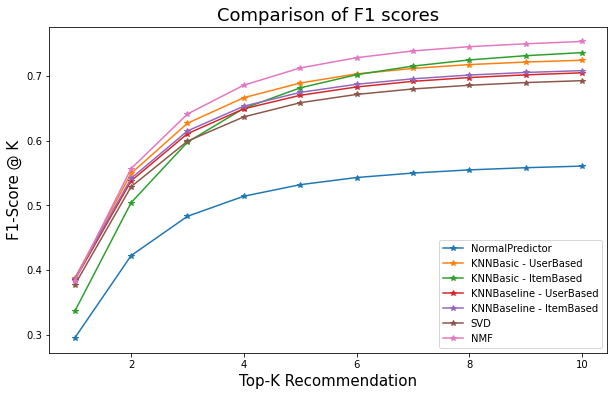

In [37]:
rcParams['figure.figsize'] = 10, 6

for model in df_result["model"].unique():
    plt.plot(df_result[df_result["model"] == model]["K"], df_result[df_result["model"] == model]["f1"], marker="*",
             label=model)

plt.legend()
plt.xlabel("Top-K Recommendation", fontsize=15)
plt.ylabel("F1-Score @ K", fontsize=15)
plt.title("Comparison of F1 scores", fontsize=18)
plt.show()

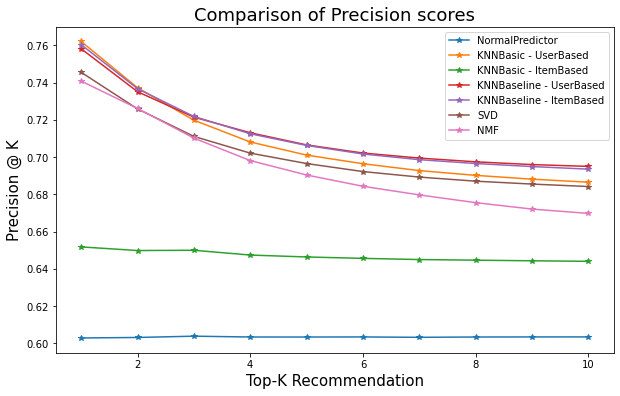

In [38]:
rcParams['figure.figsize'] = 10, 6

for model in df_result["model"].unique():
    plt.plot(df_result[df_result["model"] == model]["K"], df_result[df_result["model"] == model]["precision"], marker="*",
             label=model)

plt.legend()
plt.xlabel("Top-K Recommendation", fontsize=15)
plt.ylabel("Precision @ K", fontsize=15)
plt.title("Comparison of Precision scores", fontsize=18)
plt.show()

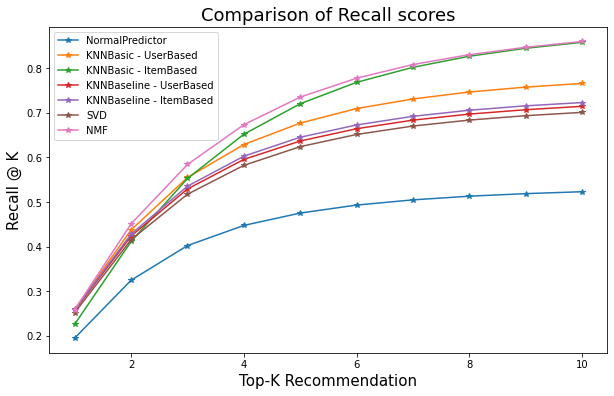

In [39]:
rcParams['figure.figsize'] = 10, 6

for model in df_result["model"].unique():
    plt.plot(df_result[df_result["model"] == model]["K"], df_result[df_result["model"] == model]["recall"], marker="*",
             label=model)

plt.legend()
plt.xlabel("Top-K Recommendation", fontsize=15)
plt.ylabel("Recall @ K", fontsize=15)
plt.title("Comparison of Recall scores", fontsize=18)
plt.show()

In [40]:
df_result = df_result.drop_duplicates(subset=["model"])

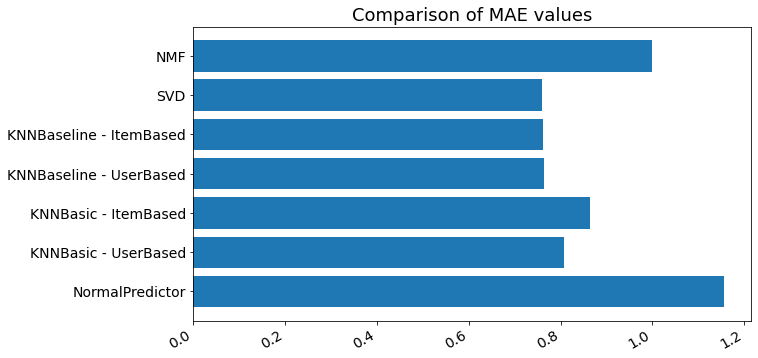

In [41]:
rcParams['figure.figsize'] = 10, 6

fig = plt.figure()
plt.barh(df_result["model"], df_result["mae"])
plt.title("Comparison of MAE values", fontsize=18)
fig.autofmt_xdate()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

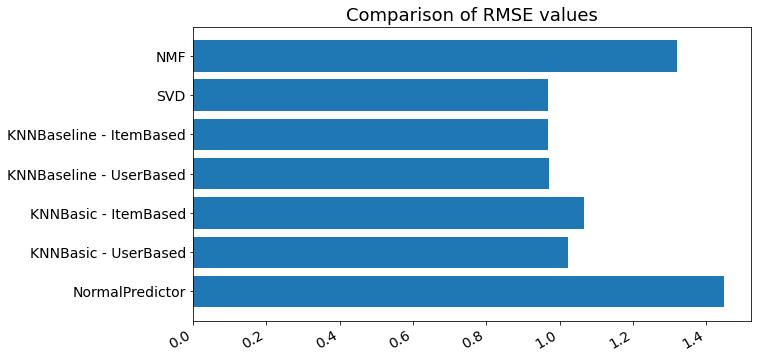

In [42]:
fig = plt.figure()
plt.barh(df_result["model"], df_result["rmse"])
fig.autofmt_xdate()
plt.title("Comparison of RMSE values", fontsize=18)
fig.autofmt_xdate()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

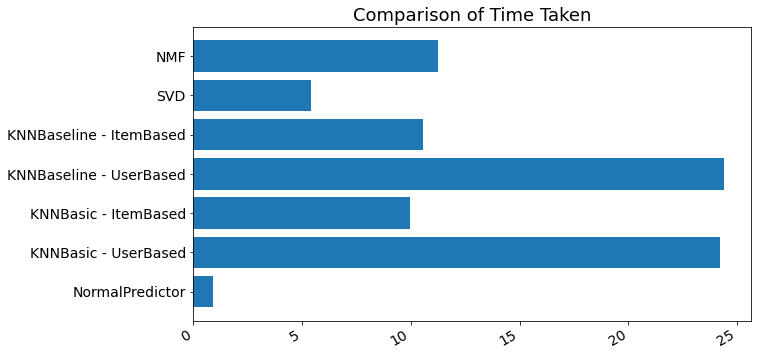

In [43]:
fig = plt.figure()
plt.barh(df_result["model"], df_result["Time Taken"])
fig.autofmt_xdate()
plt.title("Comparison of Time Taken", fontsize=18)
fig.autofmt_xdate()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Top- N Recommendations: Geolocation Based Filtering

In [44]:
from sklearn.neighbors import BallTree

In [45]:
def user_train_locations(df, testset):
    df_test = pd.DataFrame(testset)
    df_test.columns = ["reviewer_ID", "restaurant_ID", "review_rating"]
    df_train = df.merge(df_test, indicator=True, how='left').loc[lambda x : x['_merge']!='both']
    df_train.drop("_merge", axis=1, inplace=True)
    
    df_temp = df_train.merge(df_loc, on="restaurant_ID", how="left")
    df_temp["coords"] = df_temp[["rest_lat", "rest_long"]].apply(lambda x: (x[0], x[1]), axis=1)
    
    userloc_dict = df_temp.groupby("reviewer_ID")["coords"].apply(list).to_dict()

    for uid, loc_list in userloc_dict.items():
        userloc_dict[uid] = list(set(loc_list))
    
    return userloc_dict

In [46]:
def filter_predictions(predictions, userloc_dict, loc_dict, loc_threshold, verbose=True):
    new_predictions = []

    top_n = defaultdict(list)

    for uid, iid, true_r, est, v in predictions:
        top_n[uid].append((iid, true_r, est, v))
    
    if verbose:
        pbar = tqdm(total=len(top_n.keys()), desc="Progress:") 

    for uid in top_n.keys():    
        ball = BallTree(pd.DataFrame(userloc_dict[uid]).values, metric='haversine')

        df_pred = pd.DataFrame(top_n[uid])
        df_pred.columns = ["restaurant_ID", "true_rating", "est_rating", "verbose"]
        df_temp = pd.DataFrame.from_dict(loc_dict, orient="index").reset_index()
        df_temp.columns = ["restaurant_ID", "rest_lat", "rest_long"]
        distances, indices = ball.query(df_pred.merge(df_temp, on="restaurant_ID", how="left")[["rest_lat", "rest_long"]].values, k=1)
        df_pred["distance"] = distances* 6371

        df_pred = df_pred[df_pred["distance"] <= loc_threshold]

        df_pred["est_rating"] = round(df_pred["est_rating"], 2)
        df_pred["user_id"] = uid
        df_pred.sort_values(by=["est_rating", "distance"], ascending=[False, True])
        df_pred.drop("distance", axis=1, inplace=True)
        df_pred = df_pred[['user_id', 'restaurant_ID', 'true_rating', 'est_rating', 'verbose']]
        new_predictions += df_pred.values.tolist()
        if verbose:
            pbar.update(1)

    return new_predictions

In [47]:
def compare_geofiltering_ndcg(data, algo, k_list, loc_list, n_split=5):
    st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d_%H-%M')
    rec_algo = str(algo)[len("<surprise.prediction_algorithms."):str(algo).find(" ")]
    
    df_result = pd.DataFrame(columns=["Distance Threshold", "K", "NDCG@K", "Split"])
    c = 0
    
    kf = KFold(n_splits=n_split)
    
    pbar = tqdm(total=n_split*(len(loc_list) + 1), desc="Progress")
    
    # print("Buidling Anti-Trainset...")
    start_t = time.time()

    split_i = 0
    for trainset, testset in kf.split(data):
        split_i += 1
        
        # Build Anti-Trainset
        algo.fit(trainset)
        anti_trainset = trainset.build_anti_testset()
        predictions = algo.test(anti_trainset)

        # Before Geo-Filtering
        for k_th in k_list:
            ndcg_ = ndcg_at_k(predictions, testset, k_th)
            df_result.loc[c] = ["N/A", k_th, round(ndcg_, 3), split_i]
            c += 1
        pbar.update(1) 

        # Build Trainset
        userloc_dict =  user_train_locations(df_ratings.copy(deep=True), testset)
        
        # After Geo-Filtering
        for loc_th in loc_list:
            filtered_predictions = filter_predictions(predictions, userloc_dict, loc_dict, loc_th, False)
            for k_th in k_list:
                ndcg_ = ndcg_at_k(filtered_predictions, testset, k_th)
                df_result.loc[c] = [loc_th, k_th, round(ndcg_, 3), split_i]
                c += 1
            df_result.reset_index(drop=True, inplace=True)
            df_result.to_csv(os.path.join(recdir, "geo_filtering_results_" + rec_algo + str(st) + ".csv"), index=False)
            pbar.update(1) 
             
        end_t = round((time.time() - start_t)/60, 3)
    
    df_result = df_result.groupby(["Distance Threshold", "K"])["NDCG@K"].mean().reset_index()
    df_result.reset_index(drop=True, inplace=True)
    df_result.to_csv(os.path.join(recdir, "geo_filtering_results_" + rec_algo + str(st) + ".csv"), index=False)

In [48]:
df_loc = pd.read_csv(os.path.join(subdir, "restaurants_location.csv"))
df_loc["coords"] = df_loc[["rest_lat", "rest_long"]].apply(lambda x: (x[0], x[1]), axis=1)
loc_dict = dict(zip(df_loc["restaurant_ID"],df_loc["coords"]))

In [49]:
valid_rest = df_loc["restaurant_ID"].values.tolist()
df_reviews = df_reviews[df_reviews["restaurant_ID"].isin(valid_rest)]

In [50]:
loc_list = list(range(1, 6))
k_list = list(range(5, 51, 5))

In [51]:
reader = Reader(rating_scale=(1, 5))

df_ratings = df_reviews[["reviewer_ID", "restaurant_ID", "review_rating"]].copy(deep=True)
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_ratings[["reviewer_ID", "restaurant_ID", "review_rating"]], reader)

algo = SVD(n_factors=30, n_epochs=20, verbose=False)

In [52]:
reader = Reader(rating_scale=(1, 5))

df_ratings = df_reviews[["reviewer_ID", "restaurant_ID", "review_rating"]].copy(deep=True)
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_ratings[["reviewer_ID", "restaurant_ID", "review_rating"]], reader)

algo = KNNBaseline(k=60, min_k=20, verbose=False, sim_options={"name": "pearson", "user_based": False})

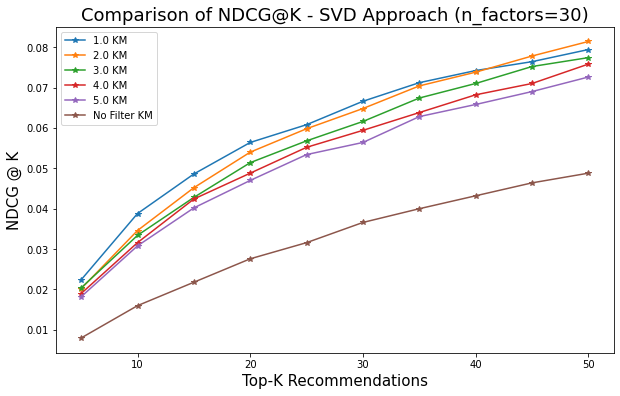

In [53]:
df_result = pd.read_csv(os.path.join(recdir, "geo_filtering_results_matrix_factorization.SVD2020-12-26_14-10.csv"))
df_result = df_result.replace(np.nan, "No Filter")

rcParams['figure.figsize'] = 10, 6

for dt in df_result["Distance Threshold"].unique():
    plt.plot(df_result[df_result["Distance Threshold"] == dt]["K"],
             df_result[df_result["Distance Threshold"] == dt]["NDCG@K"], marker="*",
             label= str(dt) + " KM")

plt.legend()
plt.xlabel("Top-K Recommendations", fontsize=15)
plt.ylabel("NDCG @ K", fontsize=15)
plt.title("Comparison of NDCG@K - SVD Approach (n_factors=30)", fontsize=18)
plt.show()

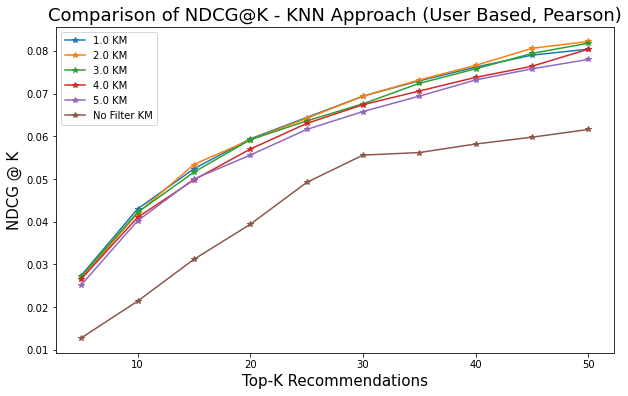

In [54]:
df_result = pd.read_csv(os.path.join(recdir, "geo_filtering_results_knns.KNNBaseline2020-12-26_16-03.csv"))
df_result = df_result.replace(np.nan, "No Filter")

rcParams['figure.figsize'] = 10, 6

for dt in df_result["Distance Threshold"].unique():
    plt.plot(df_result[df_result["Distance Threshold"] == dt]["K"],
             df_result[df_result["Distance Threshold"] == dt]["NDCG@K"], marker="*",
             label= str(dt) + " KM")

plt.legend()
plt.xlabel("Top-K Recommendations", fontsize=15)
plt.ylabel("NDCG @ K", fontsize=15)
plt.title("Comparison of NDCG@K - KNN Approach (User Based, Pearson)", fontsize=18)
plt.show()

# LightFM